In [2]:
import numpy as np
import matplotlib.pyplot as plt
from typing import Callable
from typing import Tuple
import matplotlib as mpl
from matplotlib.patches import Patch
from matplotlib.lines import Line2D


from ndgsp.graph.graphs import Graph, ProductGraph
from ndgsp.graph.filters import MultivariateFilterFunction

np.set_printoptions(precision=3, linewidth=500, threshold=500, suppress=True, edgeitems=5)

import sys
sys.path.append('..')

import scipy as sp
import os
import subprocess

from PIL import Image
from scipy.sparse.linalg import LinearOperator, cg
from tqdm.notebook import tqdm
import time

%matplotlib ipympl

In [197]:
def vec(X: np.ndarray) -> np.ndarray:
    return X.T.reshape(-1)


def mat(x: np.ndarray, shape: tuple) -> np.ndarray:
    return x.reshape((shape[1], shape[0])).T


def path_graph(N: int) -> Tuple[np.ndarray, np.ndarray]:
    """
    Get the adjacency matrix and Laplacian for a path graph

    Params:
        N       The number of nodes

    Returns:
        A       (N, N) adjacency matrix        
        L       (N, N) Laplacian matrix
    """

    A = np.zeros((N, N))
    A[range(N-1), range(1, N)] = 1
    A += A.T

    L = np.diag(A.sum(0)) - A

    return A, L


def g(lamN: float | np.ndarray, 
      lamT: float | np.ndarray, 
      betaN: float, 
      betaT: float) -> float | np.ndarray:
    """
    An example anisotropic diffusion graph filter function 

    Params:
        lamN                space eigenvalue
        lamT                time eigenvalue
        betaN               space filter parameter
        betaT               time filter parameter 

    Returns:
        g(λn, λt, βn, βt)   filter applied to eigenvalues
    """
    return np.exp(-(betaN * lamN + betaT * lamT))


def dummy_data(N: int, T: int, m: float, seed: int=0) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    """
    Generate some fake data for testing purposes with size (N, T) and
    missingness fraction 0 < m < 1

    Parameters:
        N, T        dimensions of the data
        m           the fraction of data that is missing
    """
    
    np.random.seed(seed)
    Y = np.random.normal(size=(N, T))
    S = np.ones(N * T, dtype=bool)
    S[np.random.choice(N * T, int(N * T * m), replace=False)] = False
    S = S.reshape((N, T))
    Y[S] = 0
    
    _, LN = path_graph(N)
    _, LT = path_graph(T)

    return Y, S, LN, LT


def save_fig_cropped(fname: str):
    """Save the current figure and crop out whitespace"""

    plt.savefig(fname)
    subprocess.run(['pdfcrop', fname, fname])



In [7]:
def idct(Y: np.ndarray) -> np.ndarray:
    """
    Apply IDCT matrix U to matrix of column vectors Y
    """
    return sp.fft.idct(Y.T, type=2, norm='ortho').T

def dct(Y: np.ndarray) -> np.ndarray:
    """
    Apply DCT matrix U.T to matrix of column vectors Y
    """
    return sp.fft.dct(Y.T, type=2, norm='ortho').T

def ridct(Y: np.ndarray) -> np.ndarray:
    """
    Apply matrix of row vectors Y to IDCT matrix U
    """
    return sp.fft.dct(Y, type=2, norm='ortho')

def rdct(Y: np.ndarray) -> np.ndarray:
    """
    Apply matrix of row vectors Y to DCT matrix U.T
    """
    return sp.fft.idct(Y, type=2, norm='ortho')


In [106]:
# edit this to set the maximum number of iterations
MAX_ITERS = 1e7


def direct(Y: np.ndarray, 
           S: np.ndarray, 
           LN: np.ndarray, 
           LT: np.ndarray, 
           gamma: float, 
           g: Callable, 
           decomposed_Ls: dict=None) -> np.ndarray:
    
    """
    Compute the posterior mean using direct Gaussian elimination
    """

   
    if decomposed_Ls is None:

        # decompose the graph Laplacians
        lamN, UN = np.linalg.eigh(LN)
        lamT, UT = np.linalg.eigh(LT)

    else:

        lamN, UN = decomposed_Ls['lamN'], decomposed_Ls['UN']
        lamT, UT = decomposed_Ls['lamT'], decomposed_Ls['UT']


    # compute the coefficient matrix directly using np.kron
    Hi2 = np.kron(UT, UN) @ np.diag(vec(g(lamN[:, None], lamT[None, :]) ** -2)) @ np.kron(UT.T, UN.T)

    # solve the linear system
    return mat(np.linalg.solve(gamma * Hi2 + np.diag(vec(S)), vec(Y)), Y.shape)


def SIM(Y: np.ndarray, 
        S: np.ndarray, 
        LN: np.ndarray, 
        LT: np.ndarray, 
        gamma: float, 
        g: Callable, 
        decomposed_Ls: dict=None) -> Tuple[np.ndarray, int]:
    
    """
    Perform the Stationary Iterative Method for computing the posterior mean

    Params:
        Y           (N, T) partially observed graph signal
        S           (N, T) binary sensing matrix
        LN          (N, N) space-like Laplacian matrix
        LT          (T, T) time-like Laplacian matrix
        gamma       Regularisation parameter > 0
        g           Graph filter function  

    Returns:
        F           (N, T) the posterior mean
        nits        The number of iterations
    """

    N, T = Y.shape

    if decomposed_Ls is None:

        lamN, UN = np.linalg.eigh(LN)
        lamT, UT = np.linalg.eigh(LT)

    else:

        lamN, UN = decomposed_Ls['lamN'], decomposed_Ls['UN']
        lamT, UT = decomposed_Ls['lamT'], decomposed_Ls['UT']

    G2 = g(lamN[:, None], lamT[None, :]) ** 2

    J = G2 / (G2 + gamma)

    S_ = 1 - S

    dF = UN @ (J * (UN.T @ Y @ UT)) @ UT.T

    F = dF

    nits = 0

    while (dF ** 2).sum() ** 0.5 / (N * T) > 1e-8:

        dF = UN @ (J * (UN.T @ (S_ * dF) @ UT)) @ UT.T

        F += dF

        nits += 1

        if nits == MAX_ITERS:
            print(f'Warning: Maximum iterations ({MAX_ITERS}) reached')
            break

    return F, nits


def SIM_grid(Y: np.ndarray, 
             S: np.ndarray, 
             gamma: float, 
             g: Callable) -> Tuple[np.ndarray, int]:
    
    """
    Perform the Stationary Iterative Method for computing the posterior mean, where 
    both the time-like and space-like graphs are a path graph, meaning we have 2D 
    grid data. Use the DCT to speed up where possible. 

    Params:
        Y           (N, T) partially observed graph signal
        S           (N, T) binary sensing matrix
        gamma       Regularisation parameter > 0
        g           Graph filter function  

    Returns:
        F           (N, T) the posterior mean
        nits        The number of iterations
    """

    N, T = Y.shape

    lamN = 2 - 2 * np.cos(N ** -1 * np.pi * np.arange(N))
    lamT = 2 - 2 * np.cos(T ** -1 * np.pi * np.arange(T))

    G2 = g(lamN[:, None], lamT[None, :]) ** 2

    J = G2 / (G2 + gamma)

    S_ = 1 - S

    dF = rdct(idct((J * dct(ridct(Y)))))

    F = dF

    nits = 0

    while (dF ** 2).sum() ** 0.5 / (N * T) > 1e-8:

        dF = rdct(idct((J * dct(ridct(S_ * dF)))))

        F += dF

        nits += 1

        if nits == MAX_ITERS:
            print(f'Warning: Maximum iterations ({MAX_ITERS}) reached')
            break

    return F, nits


def CGM(Y: np.ndarray, 
         S: np.ndarray, 
         LN: np.ndarray, 
         LT: np.ndarray, 
         gamma: float, 
         g: Callable, 
         decomposed_Ls: dict=None) -> Tuple[np.ndarray, int]:
    """
    Perform the Conjugate Gradient Method for computing the posterior mean

    Params:
        Y           (N, T) partially observed graph signal
        S           (N, T) binary sensing matrix
        LN          (N, N) space-like Laplacian matrix
        LT          (T, T) time-like Laplacian matrix
        gamma       Regularisation parameter > 0
        g           Graph filter function  

    Returns:
        F           (N, T) the posterior mean
        nits        The number of iterations
    """
    
    N, T = Y.shape

    if decomposed_Ls is None:

        # decompose the graph Laplacians
        lamN, UN = np.linalg.eigh(LN)
        lamT, UT = np.linalg.eigh(LT)

    else:

        lamN, UN = decomposed_Ls['lamN'], decomposed_Ls['UN']
        lamT, UT = decomposed_Ls['lamT'], decomposed_Ls['UT']


    G = g(lamN[:, None], lamT[None, :])

    def matvec(z):

        Z = mat(z, (N, T))

        out = gamma * Z + G * (UN.T @ (S * (UN @ (G * Z) @ UT.T)) @ UT)

        return vec(out)
    
    nits = 0

    def iter_count(arr):
        nonlocal nits
        nits += 1
    
    linop = LinearOperator((N * T, N * T), matvec=matvec)
    
    z, exit_code = cg(linop, vec(G * (UN.T @ Y @ UT)), callback=iter_count, maxiter=MAX_ITERS)

    return UN @ (G * mat(z, (N, T))) @ UT.T, nits
 

def CGM_grid(Y: np.ndarray, 
              S: np.ndarray, 
              gamma: float, 
              g: Callable) -> Tuple[np.ndarray, int]:
        
    """
    Perform the Conjugate GRadient Method for computing the posterior mean, where 
    both the time-like and space-like graphs are a path graph, meaning we have 2D 
    grid data. Use the DCT to speed up where possible. 

    Params:
        Y           (N, T) partially observed graph signal
        S           (N, T) binary sensing matrix
        gamma       Regularisation parameter > 0
        g           Graph filter function  

    Returns:
        F           (N, T) the posterior mean
        nits        The number of iterations
    """

    N, T = Y.shape

    lamN = 2 - 2 * np.cos(N ** -1 * np.pi * np.arange(N))
    lamT = 2 - 2 * np.cos(T ** -1 * np.pi * np.arange(T))

    G = g(lamN[:, None], lamT[None, :])

    def matvec(z):

        Z = mat(z, (N, T))

        out = gamma * Z + G * dct(ridct(S * idct(rdct(G * Z))))

        return vec(out)
    
    nits = 0

    def iter_count(arr):
        nonlocal nits
        nits += 1
    
    linop = LinearOperator((N * T, N * T), matvec=matvec)
    
    z, exit_code = cg(linop, vec(G * ridct(dct(Y))), callback=iter_count, maxiter=MAX_ITERS)

    return idct(rdct(G * mat(z, (N, T)))), nits


In [6]:
def verify_SIM_CGM():
    """
    Verify that the SIM and CGM give the correct answer to the linear system
    """

    np.random.seed(0)

    # beta should be relatively small so the matrix H is invertible
    betaN = 0.5
    betaT = 0.5
    gamma = 1

    # dimensions should be relatively small so the matrix H is invertible
    N = 10
    T = 12

    # fraction missingness
    m = 0.5

    # generate some data
    Y, S, LN, LT = dummy_data(N, T, m)
    g_ = lambda lamN, lamT: g(lamN, lamT, betaN, betaT)

    # calculate the solution directly 
    F_dir = direct(Y, S, LN, LT, gamma, g_)

    # calculate the solution using the SIM 
    F_sim1, _ = SIM(Y, S, LN, LT, gamma, g_)
    F_sim2, _ = SIM_grid(Y, S, gamma, g_)

    # calculate the solution using the CGM
    F_cgm1, _ = CGM(Y, S, LN, LT, gamma, g_)
    F_cgm2, _ = CGM_grid(Y, S, gamma, g_)

    for F_ in [F_sim1, F_sim2, F_cgm1, F_cgm2]:
        assert np.allclose(F_dir, F_, rtol=1e-4, atol=1e-4), f'{F_dir}, {F_}'

    return True

In [7]:
verify_SIM_CGM()

True

In [7]:
def butterflies_plot():
    """
    Create the butterflies plot
    """

    np.random.seed(0)

    def get_Y_and_S_uniform(Y_true, SNR=0, p=0.5, seed=0):
        """
        Given a true underlying image, add noise with a given SNR and remove pixels 
        uniformly at random with probability p
        """

        np.random.seed(seed)
        
        sig_y = 10 ** (-SNR / 20)
        Y = Y_true + sig_y * np.random.randn(*Y_true.shape)
        S = np.random.choice(2, size=Y_true.shape, p=[1-p, p]).astype(bool)
        
        Y[S] = 0
        Y_nan = Y.copy()
        Y_nan[S] = np.nan
        
        return Y_nan, Y, S


    def get_Y_and_S_rowcol(Y_true, SNR=0, p=0.5, seed=1):
        """
        Given a true underlying image, add noise with a given SNR and remove columns
        and rows of pixels a random such that a total of p% of the pixels are removed
        """
            
        np.random.seed(seed)

        N, T = Y_true.shape

        sig_y = 10 ** (-SNR / 20)
        Y = Y_true + sig_y * np.random.randn(*Y_true.shape)
        
        S = np.ones(Y_true.shape, dtype=bool)
        S[np.random.choice(range(N), size= int(N * (1 - (1-p) ** 0.5)), replace=False), :] = False
        S[:, np.random.choice(range(T), size= int(T * (1 - (1-p) ** 0.5)), replace=False)] = False
            
        Y[~S] = 0
        Y_nan = Y.copy()
        Y_nan[~S] = np.nan
        
        return Y_nan, Y, S
    

    def plot_uniform_pixels(Y_true: np.ndarray):
        """
        Create a plot showing the reconstruction process over a range of noise
        and missingness levels for uniformly removed pixels
        """

        fig1, axes1 = plt.subplots(ncols=4, nrows=3, sharex=True, sharey=True, figsize=(10, 5.5))
        fig2, axes2 = plt.subplots(ncols=4, nrows=3, sharex=True, sharey=True, figsize=(10, 5.5))

        for i, snr in enumerate([10, 0, -10]):
            
            for j, p in enumerate([0.01, 0.1, 0.25, 0.5]):
                
                gamma = [1, 0.85, 0.75, 0.2][j]
            
                Y_nan, Y, S = get_Y_and_S_uniform(Y_true, SNR=snr, p=p)
                
                F, _ =  CGM_grid(Y, S, gamma, lambda lamN, lamT: g(lamN, lamT, 2, 2))
                
                axes1[i, j].imshow(Y_nan,  interpolation='nearest', vmin=Y_true.min(), vmax=Y_true.max(), cmap='gist_gray')
                axes2[i, j].imshow(F,  interpolation='nearest', vmin=Y_true.min(), vmax=Y_true.max(), cmap='gist_gray')

                for ax in [axes1[i, j], axes2[i, j]]:
                    
                    ax.set_xticks([])
                    ax.set_yticks([])
                
        for ax, title in zip(axes1[0, :], ['$p=0.01$', '$p=0.1$', '$p=0.25$', '$p=0.5$']):
            ax.set_title(title, size='xx-large', )

        for ax, title in zip(axes1[:, 0], [r'SNR = 10 dB', 'SNR = 0 dB', 'SNR = -10 dB']):
            ax.set_ylabel(title,  size='x-large', labelpad=5)

        for ax, title in zip(axes2[:, 0], [r'SNR = 10 dB', 'SNR = 0 dB', 'SNR = -10 dB']):
            ax.set_ylabel(title,  size='x-large', labelpad=5)
            
        fig1.tight_layout()
        fig2.tight_layout()

        return fig1, fig2
    

    def plot_rowcol_pixels(Y_true: np.ndarray):
        """
        Create a plot showing the reconstruction process over a range of noise
        and missingness levels for entire columns and rows of pixels removed
        """

        fig1, axes1 = plt.subplots(ncols=4, nrows=3, sharex=True, sharey=True, figsize=(10, 5.5))
        fig2, axes2 = plt.subplots(ncols=4, nrows=3, sharex=True, sharey=True, figsize=(10, 5.5))

        for i, snr in enumerate([10, 0, -10]):
            
            for j, p in enumerate([0.01, 0.1, 0.25, 0.5]):
                
                gamma = [0.2, 0.2, 0.2, 0.1][j]
            
                Y_nan, Y, S = get_Y_and_S_rowcol(Y_true, SNR=snr, p=p)
                
                F, _ =  CGM_grid(Y, S, gamma, lambda lamN, lamT: g(lamN, lamT, 2, 2))
                
                axes1[i, j].imshow(Y_nan,  interpolation='nearest', vmin=Y_true.min(), vmax=Y_true.max(), cmap='gist_gray')
                axes2[i, j].imshow(F,  interpolation='nearest', vmin=Y_true.min(), vmax=Y_true.max(), cmap='gist_gray')

                for ax in [axes1[i, j], axes2[i, j]]:
                    
                    ax.set_xticks([])
                    ax.set_yticks([])
                
        for ax, title in zip(axes1[0, :], ['$p=0.01$', '$p=0.1$', '$p=0.25$', '$p=0.5$']):
            ax.set_title(title, size='xx-large', )

        fig1.tight_layout()
        fig2.tight_layout()

        return fig1, fig2
    

    def make_super_plot():

        im = Image.open('data/butterfly1.jpg')
        im.thumbnail((856, 856))

        Y_true = np.array(im).mean(-1)
        Y_true = (Y_true - Y_true.mean()) / Y_true.std()
        N, T = Y_true.shape

        fig00, fig01 = plot_uniform_pixels(Y_true)
        fig10, fig11 = plot_rowcol_pixels(Y_true)

        fig00.savefig('data/inputs1.jpg')
        fig01.savefig('data/outputs1.jpg')

        fig10.savefig('data/inputs2.jpg')
        fig11.savefig('data/outputs2.jpg')

        im00 = Image.open('data/inputs1.jpg')
        im01 = Image.open('data/inputs2.jpg')
        im10 = Image.open('data/outputs1.jpg')
        im11 = Image.open('data/outputs2.jpg')

        im = Image.new("RGB", (2030, 1100), "white")

        im.paste(im00, (0, 0))
        im.paste(im01, (1015, 0))
        im.paste(im10, (0, 550))
        im.paste(im11, (1015, 550))

        im.save('data/butterfly_plot.jpg')

        os.remove('data/inputs1.jpg')
        os.remove('data/outputs1.jpg')    
        os.remove('data/inputs2.jpg')    
        os.remove('data/outputs2.jpg')

        return im


    return make_super_plot()


In [8]:
%%capture 

# takes about O(25s)
im = butterflies_plot()

In [133]:
def verify_convergence_formulas():

    def rho(A):
        """Return the spectral radius of a matrix A"""
        lam = np.linalg.eigvals(A)
        return lam[np.argmax(lam)]

    def kappa(A):
        """Return the condition number of a matrix A"""
        lam = np.linalg.eigvals(A)
        return lam[np.argmax(lam)] / lam[np.argmin(lam)]
    
    N = 16
    T = 16
    NT = N * T

    m = 1 / 4
    gamma = 0.05

    Y, S, LN, LT = dummy_data(N, T, m)

    lamN, UN = np.linalg.eigh(LN)
    lamT, UT = np.linalg.eigh(LT)

    U = np.kron(UT, UN)
    S_ = 1 - S
    DS = np.diag(vec(S))
    DS_ = np.diag(vec(S_))
    

    def check_WFL():

        DG = np.eye(NT)
        DJ = DG / (1 + gamma)

        # check SIM
        rho_emp = rho(U @ DJ @ U.T @ DS_)
        rho_ana = 1 / (1 + gamma)
        assert np.isclose(rho_emp, rho_ana)

        # check CGM
        kappa_emp = kappa(DG @ U.T @ DS @ U @ DG + gamma * np.eye(N * T))
        kappa_ana = (1 + gamma) / gamma
        assert np.isclose(kappa_emp, kappa_ana)

    def check_SFL():

        DG = np.diag([1] + [0] * (NT - 1))
        DJ = DG / (1 + gamma)

        # check SIM
        rho_emp = rho(U @ DJ @ U.T @ DS_)
        rho_ana = m / (1 + gamma)
        assert np.isclose(rho_emp, rho_ana), f'{rho_emp}, {rho_ana}'

        # check CGM
        kappa_emp = kappa(DG @ U.T @ DS @ U @ DG + gamma * np.eye(N * T))
        kappa_ana = (1 - m + gamma) / gamma
        assert np.isclose(kappa_emp, kappa_ana), f'{rho_emp}, {rho_ana}'


    for gamma in np.logspace(-4, 1, 10):

        for m in [1 / 16, 1 / 8, 1 / 4, 1 / 2, 3 / 4, 7 / 8, 15 / 16]:

            Y, S, LN, LT = dummy_data(N, T, m)
            S_ = 1 - S
            DS = np.diag(vec(S))
            DS_ = np.diag(vec(S_))
    
            check_WFL()
            check_SFL()

    return True

verify_convergence_formulas()


True

PDFCROP 1.40, 2020/06/06 - Copyright (c) 2002-2020 by Heiko Oberdiek, Oberdiek Package Support Group.
==> 1 page written on `conv_SIM_CGM_compared.pdf'.


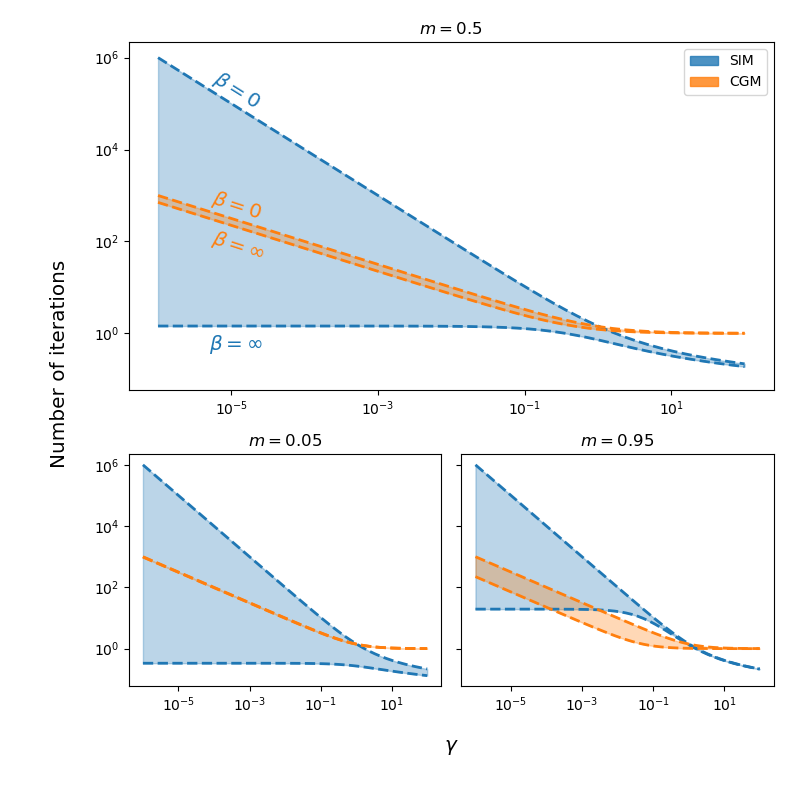

In [198]:
def make_it_gamma_plot_CGM():

    gs = np.logspace(-6, 2)

    fig, axes = plt.subplot_mosaic("AA;BC", sharey=True, figsize=(8, 8), gridspec_kw={'height_ratios': [1.5, 1]})

    y1 = (1 / gs + 1) ** 0.5
    ya = 1 / np.log(1 + gs)
    

    for ax, m in zip(axes.values(), [0.5, 0.05, 0.95]):
        
        y2 = ((1 - m + gs) / gs) ** 0.5
        yb = 1 / (np.log(1 + gs) - np.log(m))

        ax.plot(gs, ya, color='tab:blue', ls='--', lw=2)
        ax.plot(gs, yb, color='tab:blue', ls='--', lw=2)
        ax.fill_between(gs, ya, yb, alpha=0.3,  color='tab:blue')

        ax.plot(gs, y1, color='tab:orange', ls='--', lw=2)
        ax.plot(gs, y2, color='tab:orange', ls='--', lw=2)
        ax.fill_between(gs, y1, y2, alpha=0.3, color='tab:orange')

        ax.set_xscale('log')
        ax.set_yscale('log')

        ax.set_title(r'$m=' + str(m) + '$')

    fig.add_subplot(111, frameon=False)
    plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
    plt.xlabel(r"$\gamma$", size='x-large', labelpad=20)
    plt.ylabel(r'Number of iterations', labelpad=20, size='x-large')


    axes['A'].text(5e-6, 6e5, r'$\beta=0$', color='tab:blue', rotation=-32, ha='left', va='top', size='x-large')
    axes['A'].text(5e-6, 1e0, r'$\beta=\infty$', color='tab:blue', ha='left', va='top', size='x-large')

    axes['A'].text(5e-6, 1.5e3, r'$\beta=0$', color='tab:orange', rotation=-18, ha='left', va='top', size='x-large')
    axes['A'].text(5e-6, 2e2, r'$\beta=\infty$', color='tab:orange', rotation=-18, ha='left', va='top', size='x-large')

    legend_elements = [Patch(facecolor='tab:blue', edgecolor='tab:blue', label='SIM', alpha=0.8),
                       Patch(facecolor='tab:orange', edgecolor='tab:orange', label='CGM', alpha=0.8)]

    axes['A'].legend(handles=legend_elements)

    plt.tight_layout()

    save_fig_cropped('conv_SIM_CGM_compared.pdf')

make_it_gamma_plot_CGM()

In [ ]:
def make_rho_beta_plot():

    gs = {'Exponential': lambda lt, ln, b: np.exp(-b * (ln + lt)), 
        '1-hop': lambda lt, ln, b: (1 + b * (ln + lt)) ** -1, 
        'RuLu': lambda lt, ln, b: np.maximum(1 - b * (ln + lt), 0), 
        'Sigmoid': lambda lt, ln, b: 2 * (1 + np.exp(b * (lt + ln))) ** -1, 
        'Gaussian': lambda lt, ln, b: np.exp(-(b * (ln + lt) ** 2)),
        'Bandlimited': lambda lt, ln, b: ((b * (lt + ln)) <= 1).astype(float)}

    betas = np.linspace(0, 20)

    fig, axes = plt.subplots(ncols=3, nrows=2, sharey=True, sharex=True, figsize=(8, 5))
    
    N = 16
    T = 16

    gamma = 0.05

    Y, S, LN, LT = dummy_data(N, T, m=0.5)

    lamN, UN = np.linalg.eigh(LN)
    lamT, UT = np.linalg.eigh(LT)

    U = np.kron(UT, UN)
    S_ = 1 - S
    DS_ = np.diag(vec(S_))

    vmax = 1 / (1 + gamma)
    vmin = vmax * S_.sum() / (N * T)

    for fil, ax in zip(gs.keys(), axes.ravel()):
        
        g = gs[fil]
        rhos = []

        for beta in betas:

            G = g(lamN[:, None], lamT[None, :], beta)
            J = G ** 2 / (G ** 2 + gamma)
            DJ = np.diag(vec(J))

            rhos.append(np.linalg.eigvals(U @ DJ @ U.T @ DS_).max())

        ax.plot(betas, rhos)
        ax.axhline(vmax, ls='--', color='gray', alpha=0.7)
        ax.axhline(vmin, ls='--', color='gray', alpha=0.7)
        ax.set_title(fil)
        ax.set_ylim(vmin-0.08, vmax+0.08)
        
    fig.add_subplot(111, frameon=False)
    plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
    plt.xlabel(r'$\beta$', size='x-large', labelpad=20)
    plt.ylabel(r'$\rho$', rotation=0, labelpad=20, size='x-large')

    plt.tight_layout()

    plt.savefig('beta-rho-plot.pdf')

    # subprocess.run(['pdfcrop', 'beta-rho-plot.pdf', 'beta-rho-plot.pdf'])

make_rho_beta_plot()

In [5]:
def get_its_grid_graph(N, T):

    np.random.seed(0)

    gs = np.logspace(-4, 1, 25)

    Y, S, LN, LT = dummy_data(N, T, m=0.5)
    lamN, UN = np.linalg.eigh(LN)
    lamT, UT = np.linalg.eigh(LT)

    its_cgm = {}
    its_sim = {}

    for m in [0.05, 0.5, 0.95]:

        Y, S, LN, LT = dummy_data(N, T, m)

        betas = [1, 2, 5, 20]

        its_cgm[m] = {beta: [] for beta in betas}
        its_sim[m] = {beta: [] for beta in betas}

        for beta in betas:

            # print(f'm={m}, beta={beta}')

            for gamma in tqdm(gs, leave=False):

                Y_sim, i_sim = SIM(Y, S, LN, LT, gamma, lambda ln, lt: g(ln, lt, beta, beta), decomposed_Ls={'UN': UN, 'UT': UT, 'lamN': lamN, 'lamT': lamT})
                Y_cgm, i_cgm = CGM(Y, S, LN, LT, gamma, lambda ln, lt: g(ln, lt, beta, beta), decomposed_Ls={'UN': UN, 'UT': UT, 'lamN': lamN, 'lamT': lamT})

                its_sim[m][beta].append(i_sim)
                its_cgm[m][beta].append(i_cgm)

    return its_sim, its_cgm




def get_its_random_graph(N, T):

    np.random.seed(0)


    gN = Graph.random_connected(N)
    gT = Graph.random_connected(T)
    gammas = np.logspace(-6, 2)

    its_cgm = {}
    its_sim = {}

    for m in [0.05, 0.5, 0.95]:

        Y, S, LN, LT = dummy_data(N, T, m)

        betas = [1, 2, 5, 20]

        its_cgm[m] = {beta: [] for beta in betas}
        its_sim[m] = {beta: [] for beta in betas}

        for beta in betas:

            # print(f'm={m}, beta={beta}')

            for gamma in tqdm(gammas, leave=False):

                Y_sim, i_sim = SIM(Y, S, LN, LT, gamma, lambda ln, lt: g(ln, lt, beta, beta), decomposed_Ls={'UN': gN.U, 'UT': gT.U, 'lamN': gN.lam, 'lamT': gT.lam})
                Y_cgm, i_cgm = CGM(Y, S, LN, LT, gamma, lambda ln, lt: g(ln, lt, beta, beta), decomposed_Ls={'UN': gN.U, 'UT': gT.U, 'lamN': gN.lam, 'lamT': gT.lam})

                its_sim[m][beta].append(i_sim)
                its_cgm[m][beta].append(i_cgm)

    return its_sim, its_cgm

In [192]:
def f1(g, m):
    return 1 / (np.log(1 + g) - np.log(m))

def grad_f1(g, m):
    g1 = -f1(g, m) ** 2 / (1 + g)
    g2 = f1(g, m) ** 2 / m
    return g1, g2

In [181]:
g = 0.5
m = 0.5

grad_f1(g, m)

array([-0.552,  1.657])

In [186]:
gs, ms = np.meshgrid(np.logspace(-4, 1), np.linspace(1e-1, 1-1e-1))

In [194]:
g1, g2 = grad_f1(gs, ms)

In [283]:
def get_3d_iteration_data():

    N = 50
    T = 50

    gN = Graph.random_connected(N, seed=0)
    gT = Graph.random_connected(T, seed=1)

    nG = 20
    nB = 20

    gammas = np.logspace(-4, 1, nG)
    betas = np.logspace(0, 2, nB)

    gs, bs = np.meshgrid(gammas, betas)

    sim_data = {}
    cgm_data = {}

    for m in [0.05, 0.5, 0.95]:

        Y, S, LN, LT = dummy_data(N, T, m)

        its_sim = np.zeros((nG, nB))
        its_cgm = np.zeros((nG, nB))

        for bi in range(nB):
            for gi in range(nG):
                
                gamma = gammas[gi]
                beta = betas[bi]

                Y_sim, i_sim = SIM(Y, S, gN.L, gT.L, gamma, lambda ln, lt: g(ln, lt, beta, beta), decomposed_Ls={'UN': gN.U, 'UT': gT.U, 'lamN': gN.lam, 'lamT': gT.lam})
                Y_cgm, i_cgm = CGM(Y, S, gN.L, gT.L, gamma, lambda ln, lt: g(ln, lt, beta, beta), decomposed_Ls={'UN': gN.U, 'UT': gT.U, 'lamN': gN.lam, 'lamT': gT.lam})

                its_sim[gi, bi] = i_sim
                its_cgm[gi, bi] = i_cgm

        sim_data[m] = its_sim
        cgm_data[m] = its_cgm

    return gs, bs, sim_data, cgm_data


def plot_3d_iterations(gs, bs, sim_data, cgm_data):

    def axis_setup(ax):
        ax.set_zlim(0.3, 5)
        ax.set_xlabel(r'$\gamma$')
        ax.set_ylabel(r'$\beta$')
        ax.set_yticks([0, 1, 2])
        ax.set_xticks([0, -2, -4])
        ax.set_xticklabels([f'$10^{{{int(i):.0f}}}$' for i in  ax.get_xticks()])
        ax.set_yticklabels([f'$10^{{{int(i):.0f}}}$' for i in  ax.get_yticks()])
        ax.set_zticklabels([f'$10^{{{int(i):.0f}}}$' for i in  ax.get_zticks()])
        ax.view_init(21, 43)

    for m in [0.05, 0.5, 0.95]:

        fig1, ax1 = plt.subplots(subplot_kw={"projection": "3d"})
        ax1.plot_surface(np.log10(gs), np.log10(bs), np.log10(sim_data[m]).T, alpha=0.8, cmap='inferno', vmin=0.477, vmax=3.5)
        
        fig2, ax2 = plt.subplots(subplot_kw={"projection": "3d"})
        ax2.plot_surface(np.log10(gs), np.log10(bs), np.log10(cgm_data[m]).T, alpha=0.8, cmap='inferno', vmin=0.477, vmax=3.5)

        axis_setup(ax2)
        axis_setup(ax1)
        ax1.set_zlabel(r'Iteration count')

        fig1.savefig(f'3d_plot/SIM_m={m}.pdf')
        fig2.savefig(f'3d_plot/CGM_m={m}.pdf')

        subprocess.run(['pdfcrop', f'3d_plot/SIM_m={m}.pdf', f'3d_plot/SIM_m={m}.pdf'])
        subprocess.run(['pdfcrop', f'3d_plot/CGM_m={m}.pdf', f'3d_plot/CGM_m={m}.pdf'])

In [276]:
gs, bs, sim_data, cgm_data = get_3d_iteration_data()

In [284]:
%%capture

plot_3d_iterations(gs, bs, sim_data, cgm_data)

PDFCROP 1.40, 2020/06/06 - Copyright (c) 2002-2020 by Heiko Oberdiek, Oberdiek Package Support Group.
==> 1 page written on `3d_plot/SIM_m=0.05.pdf'.
PDFCROP 1.40, 2020/06/06 - Copyright (c) 2002-2020 by Heiko Oberdiek, Oberdiek Package Support Group.
==> 1 page written on `3d_plot/CGM_m=0.05.pdf'.
PDFCROP 1.40, 2020/06/06 - Copyright (c) 2002-2020 by Heiko Oberdiek, Oberdiek Package Support Group.
==> 1 page written on `3d_plot/SIM_m=0.5.pdf'.
PDFCROP 1.40, 2020/06/06 - Copyright (c) 2002-2020 by Heiko Oberdiek, Oberdiek Package Support Group.
==> 1 page written on `3d_plot/CGM_m=0.5.pdf'.
PDFCROP 1.40, 2020/06/06 - Copyright (c) 2002-2020 by Heiko Oberdiek, Oberdiek Package Support Group.
==> 1 page written on `3d_plot/SIM_m=0.95.pdf'.
PDFCROP 1.40, 2020/06/06 - Copyright (c) 2002-2020 by Heiko Oberdiek, Oberdiek Package Support Group.
==> 1 page written on `3d_plot/CGM_m=0.95.pdf'.


: 

In [9]:
its_sim, its_cgm = get_its_random_graph(50, 50)

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

In [213]:
N = 16
T = 16

Y, S, LN, LT = dummy_data(N, T, m=0.5)
lamN, UN = np.linalg.eigh(LN)
lamT, UT = np.linalg.eigh(LT)
U = np.kron(UT, UN)

S = S.astype(float)

S_ = 1 - S
DS_ = np.diag(vec(S_))
DS = np.diag(vec(S))

G = g(lamN[:, None], lamT[None, :], 2, 2)
J = G ** 2 / (G ** 2 + 1)
DJ = np.diag(vec(J))
DG = np.diag(vec(G))




In [53]:
nts = np.sort(np.array(list(set(np.sort(np.concatenate([np.logspace(1, 4).astype(int), np.linspace(1e1, 1e4).astype(int)])).tolist()))))


def get_ts():

    ts = [[], [], [], [], []]

    active = [True, True, True, True, True]

    g_ = lambda lamN, lamT: g(lamN, lamT, 0.5, 0.5)
    gamma = 1

    for nt in tqdm(nts):
        
        if not any(active):
            break

        Y, S, LN, LT = dummy_data(nt, nt)

        all_args = [(Y, S, LN, LT, gamma, g_), (Y, S, LN, LT, gamma, g_), (Y, S, LN, LT, gamma, g_), (Y, S, gamma, g_), (Y, S, gamma, g_)]

        for i, (solver, args) in enumerate(zip([direct, SIM, CGM, SIM_grid, CGM_grid], all_args)):

            if active[i]:

                t0 = time.time()
                solver(*args)
                t = time.time() - t0

                ts[i].append(t)
            
                if t > 60:
                    active[i] = False

        print(nt, np.array([ts[i][-1] for i in range(5)]))

    return ts

In [54]:
ts = get_ts()

  0%|          | 0/97 [00:00<?, ?it/s]

10 [0.002 0.001 0.001 0.001 0.001]
11 [0.004 0.    0.001 0.001 0.002]
13 [0.002 0.001 0.001 0.001 0.002]
15 [0.01  0.001 0.001 0.001 0.001]
17 [0.008 0.001 0.001 0.002 0.002]
20 [0.011 0.001 0.001 0.001 0.002]
23 [0.024 0.001 0.001 0.002 0.003]
26 [0.036 0.001 0.001 0.001 0.002]
30 [0.094 0.001 0.002 0.002 0.002]
35 [0.179 0.001 0.002 0.002 0.002]
40 [0.337 0.001 0.001 0.002 0.002]
47 [0.801 0.001 0.001 0.003 0.003]
54 [1.167 0.001 0.002 0.002 0.002]
62 [2.968 0.001 0.002 0.002 0.003]
71 [5.102 0.002 0.003 0.006 0.006]
82 [11.701  0.002  0.002  0.004  0.006]
95 [28.248  0.002  0.003  0.004  0.004]
109 [62.089  0.003  0.004  0.017  0.017]
126 [62.089  0.005  0.005  0.005  0.006]
145 [62.089  0.005  0.006  0.009  0.014]
167 [62.089  0.008  0.008  0.059  0.059]
193 [62.089  0.011  0.016  0.094  0.086]
213 [62.089  0.013  0.017  0.026  0.031]
222 [62.089  0.012  0.017  0.018  0.021]
255 [62.089  0.021  0.028  0.023  0.032]
294 [62.089  0.027  0.036  0.026  0.035]
339 [62.089  0.045  0.063 

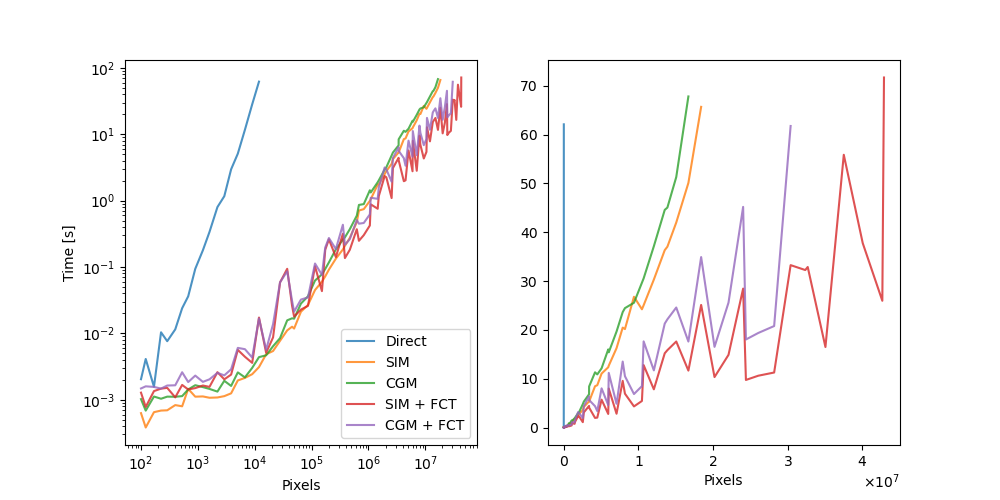

In [58]:
fig, ax = plt.subplots(ncols=2, figsize=(10, 5))

for t, label in zip(ts, ['Direct', 'SIM', 'CGM', 'SIM + FCT', 'CGM + FCT']):

    ax[0].plot(nts[:len(t)] ** 2, t, label=label, alpha=0.8)
    ax[1].plot(nts[:len(t)] ** 2, t, label=label, alpha=0.8)

ax[0].set_xscale('log')
ax[0].set_yscale('log')

ax[0].set_xlabel('Pixels')
ax[1].set_xlabel('Pixels')
ax[0].set_ylabel('Time [s]')

plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0), useMathText=True)

ax[0].legend()

plt.savefig('SIM_CGM_time.pdf')